# 建模调参

In [1]:
# import sys
# sys.path.append('/home/aistudio/external-libraries')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font', family='SimHei', size=13)
import seaborn as sns

import datetime
from tqdm import tqdm
from collections import defaultdict  

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

import pickle as cPickle

## 1. 读取数据

In [2]:
# 通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train = reduce_mem_usage(pd.read_csv('../train_data_v1.csv'))
test = reduce_mem_usage(pd.read_csv('../test_data_v1.csv'))

train_y = train['isDefault']
train_X = train.drop(['isDefault'], axis=1)
test = test.drop(['isDefault'], axis=1)
train.shape + test.shape

Memory usage of dataframe is 940800128.00 MB
Memory usage after optimization is: 229600128.00 MB
Decreased by 75.6%
Memory usage of dataframe is 235200128.00 MB
Memory usage after optimization is: 57400128.00 MB
Decreased by 75.6%


(800000, 147, 200000, 146)

## 调参方法第一种：网格调参

In [4]:
feat_names = train_X.columns 

#sklearn的学习器大多之一稀疏数据输入，模型训练会快很多
#查看一个学习器是否支持稀疏数据，可以看fit函数是否支持: X: {array-like, sparse matrix}.
#可用timeit比较稠密数据和稀疏数据的训练时间
from scipy.sparse import csr_matrix
train_X = csr_matrix(train_X)

# 五折交叉验证
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=2020)

LightGBM的主要的超参包括：
1. 树的数目n_estimators 和 学习率 learning_rate
2. 树的最大深度max_depth 和 树的最大叶子节点数目num_leaves（注意：XGBoost只有max_depth，LightGBM采用叶子优先的方式生成树，num_leaves很重要，设置成比 2^max_depth 小）
3. 叶子结点的最小样本数: min_data_in_leaf(min_data, min_child_samples)
4. 每棵树的列采样比例：feature_fraction/colsample_bytree
5. 每棵树的行采样比例：bagging_fraction （需同时设置bagging_freq=1）/subsample
6. 正则化参数lambda_l1(reg_alpha), lambda_l2(reg_lambda)

7. 两个非模型复杂度参数，但会影响模型速度和精度。可根据特征取值范围和样本数目修改这两个参数
1）特征的最大bin数目max_bin：默认255；
2）用来建立直方图的样本数目subsample_for_bin：默认200000。



### 1) 参数 n_estimators
对n_estimators，用LightGBM内嵌的cv函数调优，因为同XGBoost一样，LightGBM学习的过程内嵌了cv，速度极快。
其他参数用GridSearchCV

In [5]:
# lightgbm内嵌的交叉验证(cv)，可对连续的n_estimators参数进行快速交叉验证
# 而GridSearchCV只能对有限个参数进行交叉验证，且速度相对较慢
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.05,
          'num_leaves': 40,
          'max_depth': 7,
          'max_bin': 255,
          'subsample': 0.9,
          'bagging_freq': 1,
          'colsample_bytree': 0.9,
          'is_unbalance': 'True'
         }

lgbm_params = params.copy() 
lgbmtrain = lgbm.Dataset(train_X , train_y)

#num_boost_round为弱分类器数目
cv_result = lgbm.cv(lgbm_params, lgbmtrain, num_boost_round=10000 , nfold=5,  metrics='auc', 
                    early_stopping_rounds=1000,seed=3)

In [6]:
print('best n_estimators:' , len(cv_result['auc-mean']))
print('best cv score:' , cv_result['auc-mean'][-1])

n_estimators_1 = len(cv_result['auc-mean'])

best n_estimators: 903
best cv score: 0.7352979587568242


### 2）参数 num_leaves
num_leaves 搜索区间30-80,值越大模型越复杂，越容易过拟合

In [6]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.05,
#           'num_leaves': 100,
          'n_estimators': 903,
          'max_bin': 255,
          'subsample': 0.9,
          'bagging_freq': 1,
          'colsample_bytree': 0.9,
          'class_weight': 'balanced',
          'is_unbalance': 'True'
         }
lg = LGBMClassifier(silent=False, **params)

num_leaves_s = range(30,100,10)
tuned_parameters = dict(num_leaves = num_leaves_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv=5, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(train_X , train_y)
print('Best score is:', grid_search.best_score_)
print('Best params is:', grid_search.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 18.8min


Best score is: 0.7284226022384457
Best params is: {'num_leaves': 30}


[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed: 59.6min finished


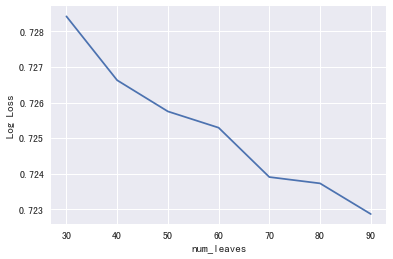

In [7]:
# plot CV误差曲线
test_means = grid_search.cv_results_['mean_test_score']
test_stds = grid_search.cv_results_['std_test_score']

n_leafs = len(num_leaves_s)

x_axis = num_leaves_s
plt.plot(x_axis, test_means)
plt.xlabel('num_leaves')
plt.ylabel('Log Loss')
plt.show()

### 3）参数 min_child_samples

In [9]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.05,
          'num_leaves': 30,
          'n_estimators': 903,
          'max_bin': 255,
          'subsample': 0.9,
          'bagging_freq': 1,
          'colsample_bytree': 0.9,
          'is_unbalance': 'True'
         }

lg = LGBMClassifier(silent=False,  **params)

min_child_samples_s = range(5,40,5) 
tuned_parameters = dict( min_child_samples = min_child_samples_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = 5, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(train_X , train_y)

print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 18.2min
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed: 52.8min finished


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [10]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7340257886519346
{'min_child_samples': 15}


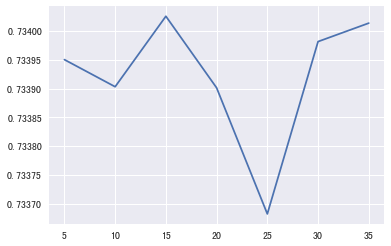

In [13]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]

x_axis = min_child_samples_s

plt.plot(x_axis, test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

### 4） 参数 colsample_bytree

In [5]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.05,
          'num_leaves': 30,
          'n_estimators': 903,
          'min_child_samples': 15,
          'max_bin': 255,
          'subsample': 0.9,
          'bagging_freq': 1,
#           'colsample_bytree': 0.9,
          'is_unbalance': 'True'
         }
lg = LGBMClassifier(silent=False,  **params)

colsample_bytree_s = [i/10.0 for i in range(5,10)]
tuned_parameters = dict(colsample_bytree = colsample_bytree_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv=5, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(train_X , train_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 14.5min
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 34.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt',
                                      class_weight=None, colsample_bytree=1.0,
                                      importance_type='split',
                                      is_unbalance='True', learning_rate=0.05,
                                      max_bin=255, max_depth=-1,
                                      min_child_samples=15,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=903,
                                      n_jobs=4, num_leaves=30,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=0.9,
                                      subsample_for_bin=200000,
                                      subsample_

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


0.7341456177557845
{'colsample_bytree': 0.6}


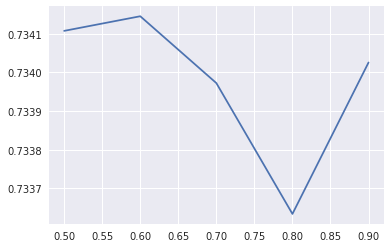

In [7]:
print(grid_search.best_score_)
print(grid_search.best_params_)

# plot CV误差曲线
test_means = grid_search.cv_results_['mean_test_score']
test_stds = grid_search.cv_results_['std_test_score']

x_axis = colsample_bytree_s

plt.plot(x_axis, test_means)
plt.show()

### 5) 参数 subsample

In [10]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.05,
          'num_leaves': 30,
          'n_estimators': 903,
          'min_child_samples': 15,
          'max_bin': 255,
#           'subsample': 0.9,
          'subsample_freq': 1,
          'colsample_bytree': 0.6,
          'is_unbalance': 'True'
         }
lg = LGBMClassifier(silent=False,  **params)

subsample_s = [i/10.0 for i in range(5,10)]
tuned_parameters = dict(subsample = subsample_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv=5, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(train_X , train_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 12.9min
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 29.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=0.6,
                                      importance_type='split',
                                      is_unbalance='True', learning_rate=0.05,
                                      max_bin=255, max_depth=-1,
                                      min_child_samples=15,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=903,
                                      n_jobs=4, num_leaves=30,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=1),
       

0.7341456177557845
{'subsample': 0.9}


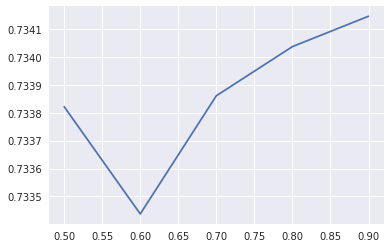

In [11]:
print(grid_search.best_score_)
print(grid_search.best_params_)

# plot CV误差曲线
test_means = grid_search.cv_results_['mean_test_score']
test_stds = grid_search.cv_results_['std_test_score']

x_axis = subsample_s

plt.plot(x_axis, test_means)
plt.show()

### 6) 参数 reg_alpha

In [12]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.05,
          'num_leaves': 30,
          'n_estimators': 903,
          'min_child_samples': 15,
          'max_bin': 255,
          'subsample': 0.9,
          'subsample_freq': 1,
          'colsample_bytree': 0.6,
          'is_unbalance': 'True',
         }
lg = LGBMClassifier(silent=False,  **params)

reg_alpha_s = [i for i in range(1,10)]
tuned_parameters = dict(reg_alpha = reg_alpha_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv=5, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(train_X , train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 15.6min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 60.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=0.6,
                                      importance_type='split',
                                      is_unbalance='True', learning_rate=0.05,
                                      max_bin=255, max_depth=-1,
                                      min_child_samples=15,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=903,
                                      n_jobs=4, num_leaves=30,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=0.9,
                                      subsample_for_bin=200000,
                                      subsample_freq=1),
       

0.7359141493779852
{'reg_alpha': 9}


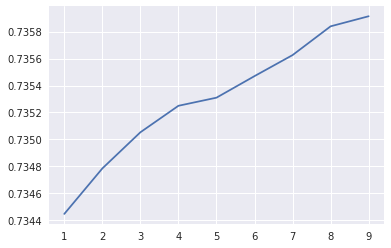

In [13]:
print(grid_search.best_score_)
print(grid_search.best_params_)

# plot CV误差曲线
test_means = grid_search.cv_results_['mean_test_score']
test_stds = grid_search.cv_results_['std_test_score']

x_axis = reg_alpha_s

plt.plot(x_axis, test_means)
plt.show()

从以上的图看到，reg_alpha的取值9的时候，auc值最高，9刚好是边缘。所以继续增大值调试。

In [14]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.05,
          'num_leaves': 30,
          'n_estimators': 903,
          'min_child_samples': 15,
          'max_bin': 255,
          'subsample': 0.9,
          'subsample_freq': 1,
          'colsample_bytree': 0.6,
          'is_unbalance': 'True',
         }
lg = LGBMClassifier(silent=False,  **params)

reg_alpha_s = [i for i in range(10,20,2)]
tuned_parameters = dict(reg_alpha = reg_alpha_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv=5, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(train_X , train_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 17.0min
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 36.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=0.6,
                                      importance_type='split',
                                      is_unbalance='True', learning_rate=0.05,
                                      max_bin=255, max_depth=-1,
                                      min_child_samples=15,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=903,
                                      n_jobs=4, num_leaves=30,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=False, subsample=0.9,
                                      subsample_for_bin=200000,
                                      subsample_freq=1),
       

0.7362700143883074
{'reg_alpha': 16}


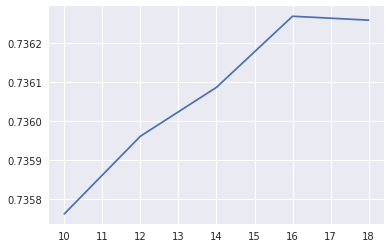

In [15]:
print(grid_search.best_score_)
print(grid_search.best_params_)

# plot CV误差曲线
test_means = grid_search.cv_results_['mean_test_score']
test_stds = grid_search.cv_results_['std_test_score']

x_axis = reg_alpha_s

plt.plot(x_axis, test_means)
plt.show()

### 7）参数 reg_lambda

In [16]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.05,
          'num_leaves': 30,
          'n_estimators': 903,
          'min_child_samples': 15,
          'max_bin': 255,
          'subsample': 0.9,
          'subsample_freq': 1,
          'colsample_bytree': 0.6,
          'reg_alpha':16,
          'is_unbalance': 'True',
         }
lg = LGBMClassifier(silent=False,  **params)

reg_lambda_s = [i for i in range(1,10,2)]
tuned_parameters = dict(reg_lambda = reg_lambda_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv=5, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(train_X , train_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 17.4min
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 37.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=0.6,
                                      importance_type='split',
                                      is_unbalance='True', learning_rate=0.05,
                                      max_bin=255, max_depth=-1,
                                      min_child_samples=15,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=903,
                                      n_jobs=4, num_leaves=30,
                                      objective='binary', random_state=None,
                                      reg_alpha=16, reg_lambda=0.0,
                                      silent=False, subsample=0.9,
                                      subsample_for_bin=200000,
                                      subsample_freq=1),
        

0.7363293503914793
{'reg_lambda': 3}


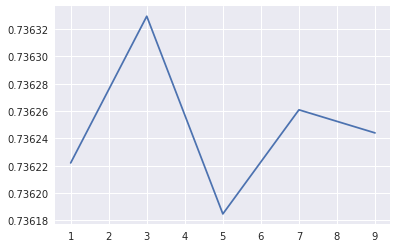

In [17]:
print(grid_search.best_score_)
print(grid_search.best_params_)

# plot CV误差曲线
test_means = grid_search.cv_results_['mean_test_score']
test_stds = grid_search.cv_results_['std_test_score']

x_axis = reg_lambda_s

plt.plot(x_axis, test_means)
plt.show()

### 8） 用调好的参数重新训练，寻找最佳的n_estimators

In [ ]:
# lightgbm内嵌的交叉验证(cv)，可对连续的n_estimators参数进行快速交叉验证
# 而GridSearchCV只能对有限个参数进行交叉验证，且速度相对较慢
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.05,
          'num_leaves': 30,
#           'n_estimators': 903,
          'min_child_samples': 15,
          'max_bin': 255,
          'subsample': 0.9,
          'subsample_freq': 1,
          'colsample_bytree': 0.6,
          'reg_alpha':16,
          'reg_lambda':3,
          'is_unbalance': 'True',
         }
lgbm_params = params.copy() 
lgbmtrain = lgbm.Dataset(train_X , train_y)

#num_boost_round为弱分类器数目
cv_result = lgbm.cv(lgbm_params, lgbmtrain, num_boost_round=15000, nfold=10, metrics='auc', 
                    early_stopping_rounds=500,seed=3)

print('best n_estimators:', len(cv_result['auc-mean']))
print('best cv score:', cv_result['auc-mean'][-1])

n_estimators_1 = len(cv_result['auc-mean'])

### 用调试好的参数进行五折交叉验证，再对测试集数据做预测，生成结果

In [24]:
# 使用lightgbm 5折交叉验证进行建模预测
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
cv_scores = []
for i, (train_index, valid_index) in enumerate(skf.split(train_X, train_y)):
    print('************************** {} ******************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = train_X[train_index], train_y[train_index], train_X[valid_index], train_y[valid_index]
    
    train_matrix = lgbm.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgbm.Dataset(X_val, label=y_val)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',  
        'learning_rate': 0.05,       
        'num_leaves': 40,
        'min_data_in_leaf': 15,     
        'feature_fraction': 0.9,
        'bagging_fraction': 0.9,
        'bagging_freq': 1,  
        'reg_alpha': 5,
        'reg_lambda': 500,
        'num_threads': 16,
        'verbose': 0,
        'is_training_metric': 'True'
    }
    
    model = lgbm.train(params, train_set=train_matrix, num_boost_round=10000, valid_sets=valid_matrix, 
                      verbose_eval=1000, early_stopping_rounds=200)
    print('best rounds:': model.best_iteration)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("\nlgb_score_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_max:{}".format(np.max(cv_scores)))


************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's auc: 0.735463
Early stopping, best iteration is:
[1346]	valid_0's auc: 0.735684
[0.7356844915471562]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's auc: 0.734395
Early stopping, best iteration is:
[883]	valid_0's auc: 0.734525
[0.7356844915471562, 0.7345245411649296]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's auc: 0.734792
Early stopping, best iteration is:
[1007]	valid_0's auc: 0.734816
[0.7356844915471562, 0.7345245411649296, 0.7348155408661515]
************************************ 4 ************************************
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration 

In [12]:
from sklearn.model_selection import train_test_split

# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(train_X, train_y, test_size=0.2)
train_data = lgbm.Dataset(X_train_split, label=y_train_split)
valid_data = lgbm.Dataset(X_val, label=y_val)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',  
    'learning_rate': 0.05,       
    'num_leaves': 50,
#     'max_depth':7,
    'min_child_samples': 30,     
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,  
    'reg_alpha': 16,
    'reg_lambda': 30,
    'min_gain_to_split': 0,
    'min_sum_hessian_in_leaf': 0.1,
    'num_threads': 16,
    'verbose': 0,
    'is_training_metric': 'True'
}

print('Hyper-parameters:')
print(params)

evals_result = {}

gbm = lgbm.train(params, train_data, valid_sets=[train_data, valid_data], 
                 valid_names = ['train', 'valid'], num_boost_round=15000, 
                 evals_result=evals_result, early_stopping_rounds=1000, verbose_eval=100)

bst_round = np.argmax(evals_result['valid']['auc'])
trn_auc = evals_result['train']['auc'][bst_round]
val_auc = evals_result['valid']['auc'][bst_round]

print('Best Round: %d'%bst_round)
print('Training AUC : %.5f, Validation AUC : %.5f'%(trn_auc, val_auc))

Hyper-parameters:
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.05, 'num_leaves': 50, 'min_child_samples': 30, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.7, 'reg_alpha': 16, 'reg_lambda': 30, 'min_gain_to_split': 0, 'min_sum_hessian_in_leaf': 0.1, 'num_threads': 16, 'verbose': 0, 'is_training_metric': 'True'}
Training until validation scores don't improve for 1000 rounds.
[100]	train's auc: 0.73351	valid's auc: 0.728214
[200]	train's auc: 0.743099	valid's auc: 0.733575
[300]	train's auc: 0.748992	valid's auc: 0.735434
[400]	train's auc: 0.753723	valid's auc: 0.736146
[500]	train's auc: 0.757796	valid's auc: 0.736573
[600]	train's auc: 0.761512	valid's auc: 0.736863
[700]	train's auc: 0.765076	valid's auc: 0.737083
[800]	train's auc: 0.768455	valid's auc: 0.737205
[900]	train's auc: 0.77175	valid's auc: 0.737249
[1000]	train's auc: 0.774964	valid's auc: 0.737231
[1100]	train's auc: 0.778061	valid's auc: 0.737251
[1200]	train's auc

#### 经过多次调试，得到验证集的AUC的分数是0.73733，用此组参数训练所有的训练数据。

## 调参方法第二种：贪心调参
lightGBM的参数比较多，这个方法也很慢，资源有限没跑出来结果

In [ ]:
from sklearn.model_selection import cross_val_score

num_leaves = range(20, 70, 10)
min_child_samples = range(10, 40, 5)
subsample = [i/10.0 for i in range(5, 10)]
colsample_bytree = [i/10 for i in range(4, 9)]
reg_alpha = range(1, 9, 1)
reg_lambda = range(1, 20, 2)
min_split_gain = [i/100.0 for i in range(1, 10)]
   
# num_leaves
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMClassifier(boosting_type='gbdt', learning_rate=0.05, objective='binary', n_estimators=1000,
                           subsample_freq=1, 
                           num_leaves=leaves)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, train_X, train_y, cv=5, scoring='roc_auc').mean()
    best_leaves[leaves] = score

In [ ]:
# min_child_samples
best_samples = dict()
for sample in min_child_samples:
    model = LGBMClassifier(boosting_type='gbdt', learning_rate=0.05, objective='binary', n_estimators=1000,
                           subsample_freq=1, 
                           num_leaves = max(best_leaves.items(), key=lambda x:x[1])[0],
                           min_child_samples=sample)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, train_X, train_y, cv=5, scoring='roc_auc').mean()
    best_samples[sample] = score

In [ ]:
# min_child_samples
best_samples = dict()
for sample in min_child_samples:
    model = LGBMClassifier(boosting_type='gbdt', learning_rate=0.05, objective='binary', n_estimators=1000,
                           subsample_freq=1, 
                           num_leaves = max(best_leaves.items(), key=lambda x:x[1])[0],
                           min_child_samples=sample)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, train_X, train_y, cv=5, scoring='roc_auc').mean()
    best_samples[sample] = score

# subsample
best_sub = dict()
for sub in subsample:
    model = LGBMClassifier(boosting_type='gbdt', learning_rate=0.05, objective='binary', n_estimators=1000,
                           subsample_freq=1, 
                           num_leaves = max(best_leaves.items(), key=lambda x:x[1])[0],
                           min_child_samples = max(best_samples.items(), key=lambda x:x[1])[0],
                           subsample=sub)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, train_X, train_y, cv=5, scoring='roc_auc').mean()
    best_sub[sub] = score
    
# colsample_bytree
best_col = dict()
for col in colsample_bytree:
    model = LGBMClassifier(boosting_type='gbdt', learning_rate=0.05, objective='binary', n_estimators=1000,
                           subsample_freq=1, 
                           num_leaves = max(best_leaves.items(), key=lambda x:x[1])[0],
                           min_child_samples = max(best_samples.items(), key=lambda x:x[1])[0],
                           subsample=max(best_sub.items(), key=lambda x:x[1])[0],
                           colsample_bytree = col)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, train_X, train_y, cv=5, scoring='roc_auc').mean()
    best_col[col] = score
    
# reg_alpha
best_l1 = dict()
for l1 in reg_alpha:
    model = LGBMClassifier(boosting_type='gbdt', learning_rate=0.05, objective='binary', n_estimators=1000,
                           subsample_freq=1, 
                           num_leaves = max(best_leaves.items(), key=lambda x:x[1])[0],
                           min_child_samples = max(best_samples.items(), key=lambda x:x[1])[0],
                           subsample=max(best_sub.items(), key=lambda x:x[1])[0],
                           colsample_bytree = max(best_col.items(), key=lambda x:x[1])[0],
                           reg_alpha=l1)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, train_X, train_y, cv=5, scoring='roc_auc').mean()
    best_l1[l1] = score
    
# reg_lambda
best_l2 = dict()
for l2 in reg_lambda:
    model = LGBMClassifier(boosting_type='gbdt', learning_rate=0.05, objective='binary', n_estimators=1000,
                           subsample_freq=1, 
                           num_leaves = max(best_leaves.items(), key=lambda x:x[1])[0],
                           min_child_samples = max(best_samples.items(), key=lambda x:x[1])[0],
                           subsample=max(best_sub.items(), key=lambda x:x[1])[0],
                           colsample_bytree = max(best_col.items(), key=lambda x:x[1])[0],
                           reg_alpha=max(best_l1.items(), key=lambda x:x[1])[0],
                           reg_lambda=l2)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, train_X, train_y, cv=5, scoring='roc_auc').mean()
    best_l2[l2] = score

## 预测测试集数据，并保存结果

In [14]:
train_matrix = lgbm.Dataset(train_X, label=train_y)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',  
    'learning_rate': 0.05,       
    'num_leaves': 52,
#     'max_depth':7,
    'min_child_samples': 30,     
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,  
    'reg_alpha': 16,
    'reg_lambda': 30,
    'min_gain_to_split': 0,
    'min_sum_hessian_in_leaf': 0.1,
    'num_threads': 16,
    'verbose': 0,
    'is_training_metric': 'True'
}

model = lgbm.train(params, train_set=train_matrix, valid_sets=train_matrix, num_boost_round=20000, verbose_eval=100, early_stopping_rounds=1000)
test_pred = model.predict(test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.733261
[200]	training's auc: 0.74238
[300]	training's auc: 0.74793
[400]	training's auc: 0.752161
[500]	training's auc: 0.755728
[600]	training's auc: 0.759081
[700]	training's auc: 0.762217
[800]	training's auc: 0.765138
[900]	training's auc: 0.767986
[1000]	training's auc: 0.770818
[1100]	training's auc: 0.773509
[1200]	training's auc: 0.77617
[1300]	training's auc: 0.778869
[1400]	training's auc: 0.781434
[1500]	training's auc: 0.783898
[1600]	training's auc: 0.786423
[1700]	training's auc: 0.788758
[1800]	training's auc: 0.791141
[1900]	training's auc: 0.793432
[2000]	training's auc: 0.795805
[2100]	training's auc: 0.79803
[2200]	training's auc: 0.80033
[2300]	training's auc: 0.802576
[2400]	training's auc: 0.804706
[2500]	training's auc: 0.806842
[2600]	training's auc: 0.809017
[2700]	training's auc: 0.811111
[2800]	training's auc: 0.813154
[2900]	training's auc: 0.815151
[3000]	training's auc:

In [15]:
sub = pd.DataFrame()
sub['id'] = test.index
sub['isDefault'] = test_pred
sub.to_csv('../submission_0923_v2.csv',index=False)

### 查看lightGBM模型下特征重要性的排序

In [5]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',  
    'learning_rate': 0.05,       
    'num_leaves': 50,
    'max_depth':7,
    'min_child_samples': 30,     
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,  
    'reg_alpha': 16,
    'reg_lambda': 30,
    'min_gain_to_split': 0,
    'min_sum_hessian_in_leaf': 0.1,
    'num_threads': 16,
    'verbose': 0,
    'is_training_metric': 'True'
}
lg = LGBMClassifier(silent=False,  **params)
lg.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', is_training_metric='True',
               learning_rate=0.05, max_depth=7, metric='auc',
               min_child_samples=30, min_child_weight=0.001,
               min_gain_to_split=0, min_split_gain=0.0,
               min_sum_hessian_in_leaf=0.1, n_estimators=100, n_jobs=-1,
               num_leaves=50, num_threads=16, objective='binary',
               random_state=None, reg_alpha=16, reg_lambda=30, silent=False,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=1,
               verbose=0)

In [7]:
pd.set_option('display.max_rows',None)
df = pd.DataFrame({"columns":list(feat_names), "importance":list(lg.feature_importances_.T)})
df = df.sort_values(by=['importance'],ascending=False)
df

,columns,importance
38,issueDateDT,564
0,annualIncome,340
5,employmentTitle,287
32,revolBal,247
13,loanAmnt,234
3,dti,234
35,term,190
91,new2+14,185
6,ficoRangeHigh,176
11,installment,157
